### Volatility Modeling, Master Mathematics for Finance and Data (MFD), Ecole des Ponts ParisTech and Université Gustave Eiffel, 2023-24
# Computing assignment  - CADIOU Tom

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm
plt.rc('figure', figsize=(6, 5.5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

# 1. Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $\mathbb{E}\left[Y|X\right]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$\mathbb{E}\left[Y|X\right]=f^{\ast}(X)\quad\text{and}\quad\mathbb{E}\left[\left|Y-f^{\ast}(X)\right|^2\right]\leq\mathbb{E}\left[\left|Y-f(X)\right|^2\right]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $\mathbb{E}\left[\left.Y\right|X\right] = \mathbb{E}\left[\left.g(X)+\varepsilon\right|X\right] = g(X)+\mathbb{E}\left[\left.\varepsilon\right|X\right] = g(X)$.

Text(0, 0.5, 'Y')

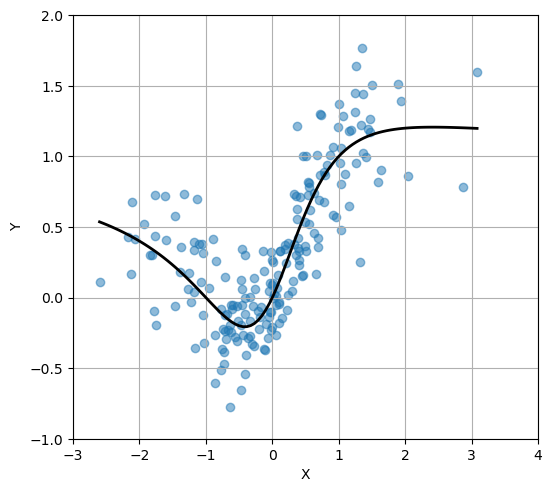

In [2]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.

def g(x):
    return x*(1+x)/(1+x**2)

n = 200
sigma = 0.25
X = np.random.randn(n)
Y = g(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)
ax.plot(x, g(x), 'k', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Parametric regression

The conditional expection $\mathbb{E}\left[\left.Y\right|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$\mathbb{E}\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where 

$$\mathbb{E}\left[\left(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X)\right)^2\right] = \min_{\beta_1,\ldots,\beta_n}\mathbb{E}\left[\left(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X)\right)^2\right]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\beta\|A\beta-y\|_2$, where

$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> can be used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

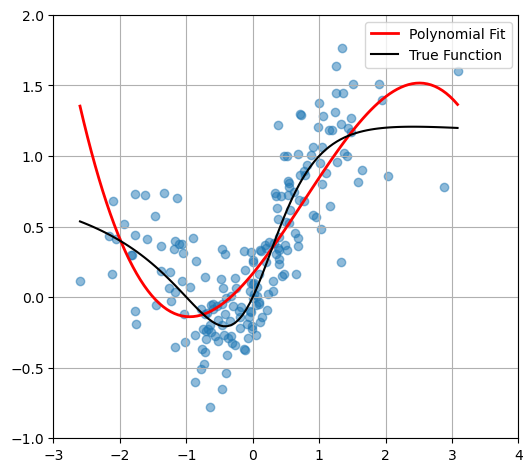

In [3]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
p = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)

### Piecewise Linear Regression

In [4]:
def pwlin_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
#     fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: x-xknots[0]]
    fs = [lambda x: np.ones_like(x, dtype=float), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))])
    return fs

def pwlin_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlin_basis(xknots)
    A = np.column_stack([f(xdata) for f in fs])
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

Text(0, 0.5, 'Y')

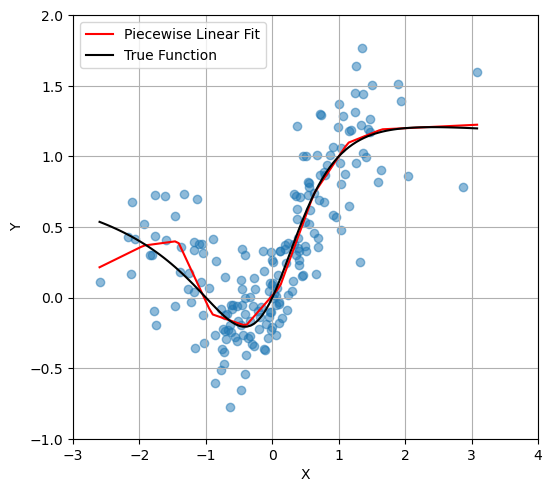

In [5]:
xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 8)
ps, fs = pwlin_fit(X, Y, xknots)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X=x\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)/h$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

In [6]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)                              ## K_h(x)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)     ## E[Y|X=x]


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern ):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.column_stack((np.ones_like(xdata), xdata-xx))*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy
    
    return np.vectorize(func)(x)

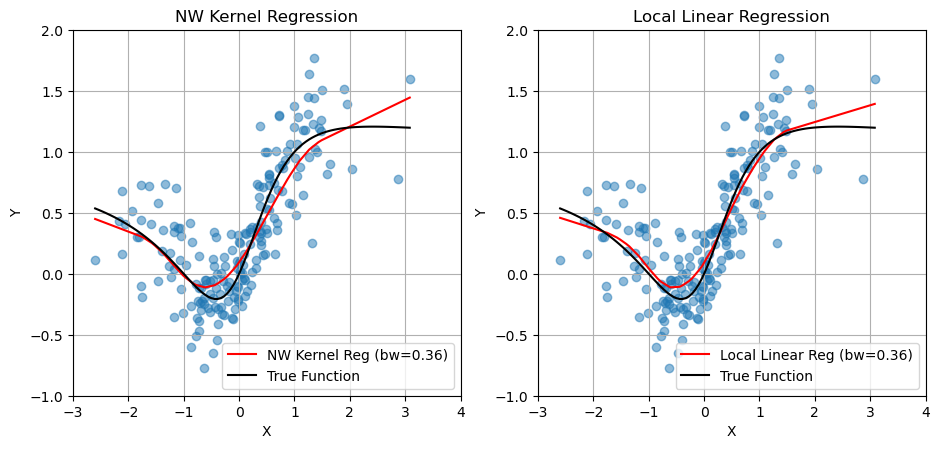

In [7]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
yknots0 = kern_reg(xknots0, X, Y, bw_silverman, gauss_kern)
f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
axs[0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
# Local Linear Regression
xknots1 = xknots0
yknots1 = ll_reg(xknots1, X, Y, bw_silverman, gauss_kern)
f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
axs[1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

## Questions

<b>(a)</b>. (Parametric regression) In general, increasing the number of basis functions in the regression gives us more flexibility to better fit the data. However, having too many parameters in the model oftentimes leads to overfitting, which usually has poor predictive performance and is over-sensitive to small noise in the data. To observe the overftting phenomenon, in polynomial fit, try to use different degrees of the polynomials; in piecewise-linear regression, try to use different numbers of knots. Then reproduce the scatter plot with fitted regression function. Compare and comment on the results.

#### Polynomial overfitting

Text(0.5, 1.0, 'Polynomial overfitting')

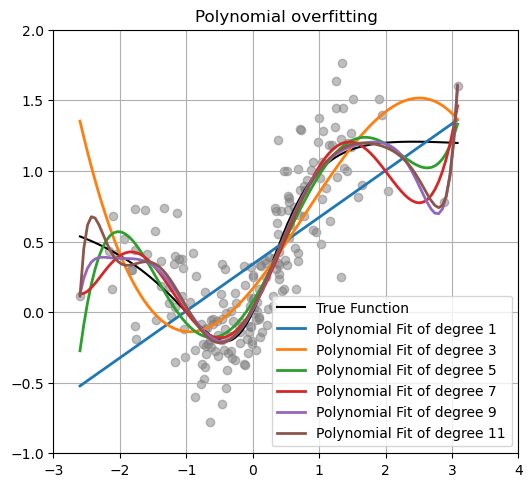

In [8]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
fig, ax = plt.subplots()
ax.plot(x, g(x), 'k', label='True Function')
for k in range(1,12,2): # taking only odd degree is not limiting because the main coefficient may be 0 if it conduces to better fit
    degree = k
    p = np.polyfit(X, Y, deg=degree)
    ax.plot(x, np.polyval(p, x), lw=2, label='Polynomial Fit of degree ' + str(degree))
    ax.legend(loc=0)
ax.scatter(X, Y, c='grey', alpha=0.5)
ax.set_title('Polynomial overfitting')

One may observe here that the more the degree the more the fitted regression function overfit the problem and the highest the variance. The choice of cubic spline, namely polynomial degree for regression equals to 3, seems quite appropriate toward our problem. 

#### Piecewise-linear regression overfitting

Text(0.5, 1.0, 'Piecewise-linear regression overfitting')

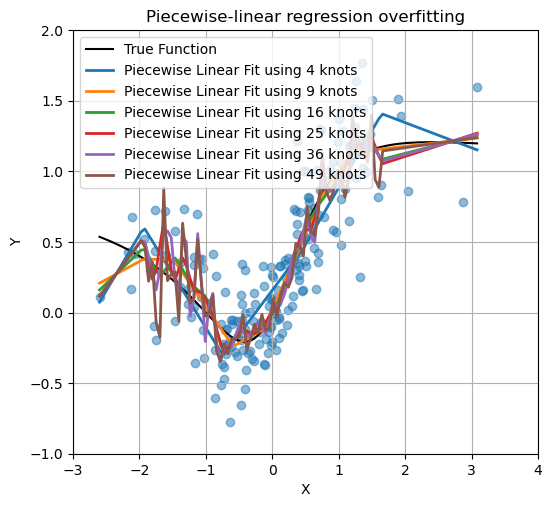

In [9]:
fig, ax = plt.subplots()
ax.plot(x, g(x), 'k', label='True Function')

for k in range(2,8):
    xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), k**2)
    ps, fs = pwlin_fit(X, Y, xknots)
    ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), label='Piecewise Linear Fit using ' + str(k**2) + ' knots', lw=2)
    ax.legend(loc=0)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
ax.scatter(X, Y, alpha=0.5)
ax.set_title('Piecewise-linear regression overfitting')

Just like the degree of the polynomial function, the bigger the number of knots the bigger the piecewise-linear regression function over-fits.

<b>(b)</b>. For nonparametric regression,
<ul>
<li>Try different bandwidth values in the kernel regression. Reproduce the scatter plot with fitted regression function. Compare and comment on the results. For what values of the bandwidth do we observe overfitting? For what values of the bandwidth do we observe a poor fit?</li>
<li>Try to use different kernels, for example
$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere.}$$
Which has more impact: the bandwidth $h$ or the kernel $K$?
</ul>

#### Bandwidth overfitting

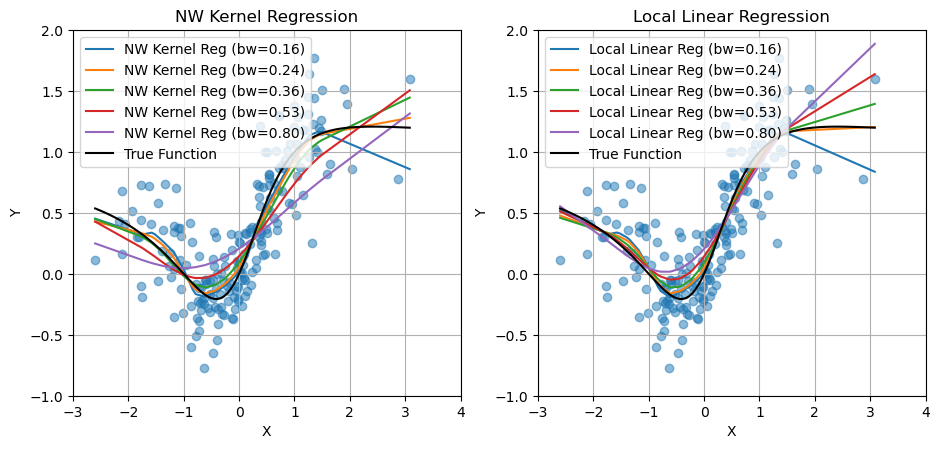

In [10]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)/(3/2)**2    ## initial value chosen so as to have bw = 0.38 centered

xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
xknots1 = xknots0

for k in range(5):

    # NW Kernel Regression
    yknots0 = kern_reg(xknots0, X, Y, bw_silverman, gauss_kern)
    f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
    axs[0].plot(x, f0(x), label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
    
    # Local Linear Regression
    yknots1 = ll_reg(xknots1, X, Y, bw_silverman, gauss_kern)
    f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
    axs[1].plot(x, f1(x), label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
    
    bw_silverman*=3/2 ## increasing bandwidth for the next loop

axs[0].set_title('NW Kernel Regression')
axs[1].set_title('Local Linear Regression')

for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

One may observe here that too large bandwidth conduces to poorfitting while too small ones actually conduce to overfitting as we can see above. Moreover, the highest the bandwidth the highest the bias while the smallest the bandwidth the highest the variance : to deal with these issues choosing a bandwidth clearly is essential so as to optimize this bias-variance negative correlation. The choice of a bandwidth $b$ verifying $b \approx 0.35$ seems reasonable for a problem such as ours.

The idea is now to observe the fitting as a function of the kernel we choose. A first kernel (excepting gaussian kernel) we can study is the quartic kernel provided above. Here is its implementation :

In [11]:
def quartic_kern(x):
    """quartic kernel function"""
    x = np.clip(x, -1, 1)
    return (x+1)**2*(1-x)**2

A first remark one may highlight is that this kernel will allow us to reduce the number of terms we are actually summing while processing the particle method below (unlike the gaussian kernel which sums all the N terms of the simulation and really is time-consuming indeed).

In [12]:
# defining kern_reg and ll_reg generalization for the use of any kernel

def kern_reg_gen(x, xdata, ydata, bandwidth, kern):
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)    

def ll_reg_gen(x, xdata, ydata, bandwidth, kern):
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.column_stack((np.ones_like(xdata), xdata-xx))*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy
    return np.vectorize(func)(x)

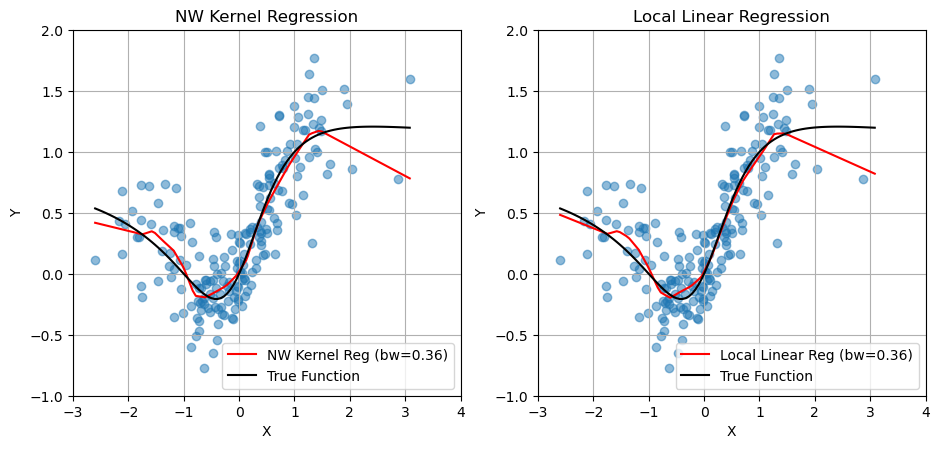

In [13]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
yknots0 = kern_reg_gen(xknots0, X, Y, bw_silverman, kern = quartic_kern)
f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
axs[0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
# Local Linear Regression
xknots1 = xknots0
yknots1 = ll_reg_gen(xknots1, X, Y, bw_silverman, kern = quartic_kern)
f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
axs[1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

One may easily notice that the choice of the kernel does not matter as much as bandwidth's. The change of kernel function here qualitatively impacts as much as a bandwidth $b$ such as, if we denote by $b_{opt}$ the actual bandwidth we use above then : $$ b \in [b_{opt} - \frac{b_{opt}}{2} ; b_{opt} + \frac{b_{opt}}{2}]$$
So the choice of the bandwidth clearly is the most important for our problem. However, the use of quartic kernel is about to make our algorithm gain some time.

# 2. The Particle Method and Smile Calibration

<!--<h3 style="color:deepskyblue">The Particle Method and Smile Calibration</h3>-->

Consider the stochastic local volatility (SLV) model

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $S_0 = 100$.
- $\sigma_0 = 15\%$.
- $Y_0 = 0$.
- $\rho = -50\%$.
- $\gamma = 50\%$.
- $\kappa = 1$.

The goal is to find a leverage function $l(t, S)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 15\%$. In that case, we also have $\sigma_{\textrm{loc}}(t,S) \equiv 15\%$.

Below we describe a Monte Carlo simulation scheme for the SLV model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $Y$ is explicitly solvable:
\begin{equation}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{-\kappa\left(t_i-s\right)}dW_s^{(2)}.
\end{equation}

Therefore for given $Y_{t_{i-1}}$, $Y_{t_i}$ is a Gaussian variable with 
\begin{equation}\tag{1}
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}

so that paths of $Y$ can be simulated exactly.

To simualte the spot process $S$, we use the Euler scheme:
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\int_{t_{i-1}}^{t_i}dW^{(1)}_t$$

Thus for given $S_{t_{i-1}}$ and $Y_{t_{i-1}}$, $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables with

\begin{equation}\tag{2}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i
\end{equation}

\begin{equation}\tag{3}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\quad\text{or}\quad
\text{Corr}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1)-(3). That is,

\begin{align}
\log S_{t_i} &= \log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\sqrt{\Delta t_i}\left(\sqrt{1-\bar{\rho}^2}Z_1+\bar{\rho}Z_2\right),\quad\text{where }\bar{\rho}=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}\\
Y_{t_i} &= e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\gamma\sqrt{\frac{1-e^{-2\kappa\Delta t_i}}{2\kappa}}Z_2
\end{align}
where $Z_1$ and $Z_2$ are independent standard normal variables.

## Questions

<b>(a).</b> Implementation of the Particle Method.
- Implement the particle method studied in class to find the leverage function $l$. For this purpose, you may use the zero-th order non-parametric regression routine provided in the first exercise. We suggest that you use the quartic kernel

$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth 

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.15)}N^{-0.2}$$

at discretization date $t_k$. Make sure to fine-tune the dimensionless bandwidth parameter $\kappa$. Its order of magnitude is 1.0. Use $\Delta t = 1/100$, $N=10,000$ paths. Note: In class, we described an acceleration technique that involves sorting the "particles" $(S_{t_k},a_{t_k})$ according to the spot value $S_{t_k}$. Since the kernel we have chosen has compact support and is fairly inexpensive to evaluate, you may ignore this acceleration technique here. This means that each estimation of a conditional expectation $\mathbb{E}\left[\left.a_{t_k}^2\right\vert S_{t_k}=x\right]$ (for $x$ in a grid of spot values) involves the ratio of two sums of $N$ terms each. Pick the grid $(x_1^{(t)},\cdots,x_p^{(t)})$ of spot values at date $t$ as follows: define $x_1^{(t)}$ as the $q$ quantile of the market risk neutral distribution of $S_t$ (in our case, a lognormal distribution), and $x_p^{(t)}$ as the $1-q$ quantile. This means that $\mathbb{P}(S_t\le x_1^{(t)}) = q$ and $\mathbb{P}(S_t\le x_p^{(t)}) = 1-q$. Then take $p$ equally spaced points $x_i$ between $x_1$ and $x_p$. Take for instance $p=50$ and $q=0.001$; you may vary those numerical parameters. To speed up the code, one may compute the quantiles $x_1^{(t)}$ and $x_p^{(t)}$ at only a few dates $t$, and then interpolate in time.

- Check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 15\%$. To this end, compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $70, 80, 90, 100, 110, 120, 130, 140$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, simulate a new set of independent paths with the calibrated leverage function $l$ and $N_2 = 100,000$ paths. For the inversion of the Black-Scholes formula, you can use the function <code>blackscholes_impv</code> provided below.

In [14]:
### Parameters needed
T     = 1     # horizon
Δ_T   = T/100 # pas de discrétisation
N     = 100000 # nombre total de trajectoires
S0    = 100   # initial spot
Y0    = 0
σ_0   = 0.15
σ_mkt = 0.15
σ_loc = 0.15
ρ = -0.50  # (Y,S) correlation rate
γ = 0.50
κ = 1
discret_scale_opt = 50
q = 0.01

### Euler step 

In [15]:
S = S0*np.ones(N) #initialisation des N traj de l'EDS du sous-jacent
Y = Y0*np.ones(N) #initialisation des N traj de l'EDS Ornstein-Uhlenbeck

def euler_step(S, Y, N, σ_0, Δ_T, ρ, κ, γ, T, k, L_t_S):
    g1       = np.random.normal(0,1,N) #génération d'un vecteur de gaussiennes centrées réduites
    g2       = np.random.normal(0,1,N) #génération d'un vecteur de gaussiennes centrées réduites
    ρ_bar    = ρ*np.sqrt(2*(1-np.exp(-κ*Δ_T))/(κ*Δ_T*(1+np.exp(-κ*Δ_T))))
    # using the expression of the discreticized solution
    S[k+1,:] = S[k,:]*np.exp( -0.5*((σ_0*L_t_S*np.exp(Y[k,:]))**2)*Δ_T + σ_0*L_t_S*np.exp(Y[k,:])*np.sqrt(Δ_T)*(np.sqrt(1-ρ_bar**2)*g1 + ρ_bar*g2)) 
    Y[k+1,:] = Y[k,:]*np.exp(-κ*Δ_T) + γ*np.sqrt((1 - np.exp(-2*κ*Δ_T))/(2*κ))*g2
    
    return S,Y

### Interpolation

In [16]:
def approximation(S, Y, k, T, discret_scale, q, kern, σ_mkt, σ_loc, σ_0, degree, method):
    t_k = (k+1)*Δ_T
    h = κ * σ_mkt * S0 * np.sqrt(max(t_k,0.15)) * N **(-0.2) # as mentionned above
    ## setting q = 0.001 causes SVD does not converge in Linear Least Squares, I decided to set q = 0.01
    Sknots = np.linspace(np.percentile(S[k+1,:], q*100), np.percentile(S[k+1,:], (1-q)*100), discret_scale) ## discret_scale stands for the number of S_knots I choose to use for discretizing
    a_t = σ_0*np.exp(Y[k+1,:])
    if method == 'NW' :
    # NW Kernel Regression
        aknots = kern_reg(Sknots, S[k+1,:], a_t**2, h, kern)
    if method == 'LL' :
    # Local Linear Regression
        aknots = ll_reg(Sknots, S[k+1,:], a_t**2, h, kern)
    ## print(np.isnan(aknots).any()) may be a source of SVD non-convergence
    ## print("Negative values:", aknots[aknots <= 0])
    L_knots = σ_loc / np.sqrt(abs(aknots))
    ## print('Lknots = ', L_knots)
    coefficients, _, _, _ = np.linalg.lstsq(np.vander(Sknots, degree + 1), L_knots, rcond=1e-6) # this method surely converges while others that I tried do not
    polynome = np.poly1d(coefficients)

    return polynome

### Particle method

In [17]:
def particle_method(N, S0, Y0, σ_0, Δ_T, ρ, κ, γ, T, σ_mkt, discret_scale, q, kern = quartic_kern, degree = 3, method_ = 'NW'):
    ## Computing the particle method studied in class ##
    
    ## degree = 3 for cubic spline interpolation
 
    S = np.zeros((int(T/Δ_T),N))
    Y = np.zeros((int(T/Δ_T),N))
    Y[0,:] = Y0 # initialisation du vecteur Y
    S[0,:] = S0 # initialisation du vecteur S
    L_t_S = np.ones(N)
    L_list = [np.poly1d([1])] # initialization

    for k in range(int(T/Δ_T)-1):

        S, Y = euler_step(S, Y, N, σ_0, Δ_T, ρ, κ, γ, T, k, L_t_S)
        polynome = approximation(S, Y, k, T, discret_scale, q, kern, σ_mkt, σ_loc, σ_0, degree, method = method_)
        L_t_S = polynome(S[k+1,:])
        L_list.append(polynome)

    return S, L_list

# test of the function
S, L_list = particle_method(N, S0, Y0, σ_0, Δ_T, ρ, κ, γ, T, σ_mkt, discret_scale_opt, q, kern = quartic_kern, degree = 3)

### Black-Scholes pricing

In [18]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option.
    S: scalar or array_like
        The spot price of the underlying security.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    w = vol**2*T
    d1 = (np.log(F/K)+0.5*w)/np.sqrt(w)
    d2 = d1 - np.sqrt(w)
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T)
    return price

In [19]:
# all inputs must be scalar
# function provided
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500): 
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
blackscholes_impv(K=100, T=0.25, S=90, value=7, callput='call')

array(0.59926784)

### Implied volatility calculation 

In [20]:
def implied_volatility_calculus(S0, Y0, T, K, Δ_t, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale, q, kern = quartic_kern, deg = 3, method = 'NW', leverage='variable'):
## compute the implied vol of a call on the spot describe above

    _, L_list = particle_method(N1, S0, Y0, σ_0, Δ_T, ρ, κ, γ, T, σ_mkt, discret_scale, q, kern = quartic_kern, degree = deg, method_ = method)
    S = np.zeros((int(T/Δ_T),N2))
    Y = np.zeros((int(T/Δ_T),N2))
    Y[0,:] = Y0
    S[0,:] = S0
    L_t_S = np.ones(N2)

    for k in range(int(T/Δ_T)-1):
        if leverage == 'variable':  # useful for smile volatility when considering constant laverage function (pure stochastic vol model)
            L_t_S = np.polyval(L_list[k], S[k,:])
        ## if not then it is a pure stochastic volatility model so the parameter 'leverage' is set to 'const' and leverage function is equal to 1 (we will be able to see this choice of parameter below)
        S,Y = euler_step(S,Y,N2,σ_0,Δ_T,ρ,κ,γ,T,k,L_t_S)

    #print(S[-1, :])
    call_prices = np.maximum(S[-1, :] - K, 0)
    #print(call_prices)
    call_price = np.mean(call_prices)
    if call_price <= 0:
        implied_vol = np.nan # source of potential rerun below
    else:
        implied_vol = blackscholes_impv_scalar(K, T, S0, call_price, r=0, q=0, callput='call', tol=1e-6, maxiter=500)

    return implied_vol

In [21]:
# testing
#implied_volatility_calculus(S0, Y0, T, 95, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, kern = quartic_kern, deg = 3, method = 'NW')

In [22]:
strike = [70, 80, 90, 100, 110, 120, 130, 140]
N1 = 100000
N2 = 100000
discret_scale_list = [10, 30, 50]

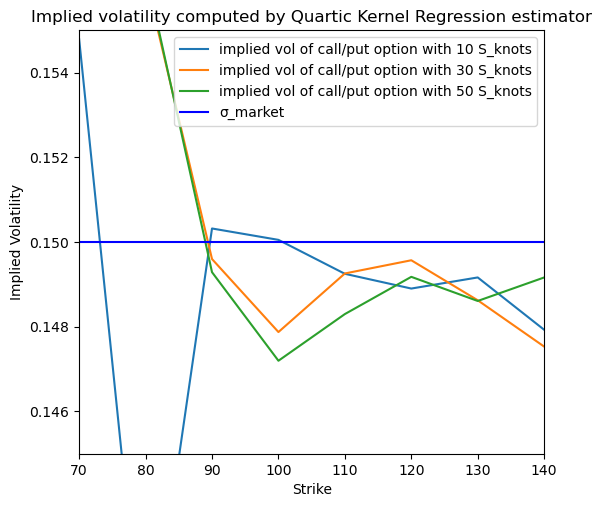

In [23]:
for discret_scale in discret_scale_list:
    ### NW Kernel Regression estimation
    if discret_scale == 50: # not to be calculated once again
        NW_implied_vols_opt = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale, q, kern = quartic_kern, deg = 3, method = 'NW') for K in strike]
        plt.plot(strike, NW_implied_vols_opt, label='implied vol of call/put option with ' + str(discret_scale) + ' S_knots')
    else:    
        NW_implied_vols = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale, q, kern = quartic_kern, deg = 3, method = 'NW') for K in strike]
        plt.plot(strike, NW_implied_vols, label='implied vol of call/put option with ' + str(discret_scale) + ' S_knots')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.ylim(0.145,0.155) # centered on σ_mkt
plt.axhline(σ_mkt, color = 'b', label='σ_market')
plt.title('Implied volatility computed by Quartic Kernel Regression estimator')
plt.legend()
plt.grid()
plt.show()

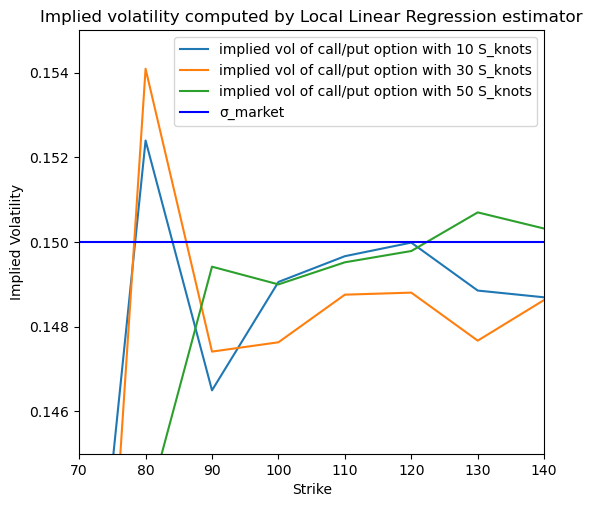

In [46]:
for discret_scale in discret_scale_list:
    ### Local Linear Regression estimation
    if discret_scale == 50: # not to be calculated once again
        LL_implied_vols_opt = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale, q, kern = quartic_kern, deg = 3, method = 'LL') for K in strike]
        plt.plot(strike, LL_implied_vols_opt, label='implied vol of call/put option with ' + str(discret_scale) + ' S_knots')
    else:
        LL_implied_vols = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale, q, kern = quartic_kern, deg = 3, method = 'LL') for K in strike]
        plt.plot(strike, LL_implied_vols, label='implied vol of call/put option with ' + str(discret_scale) + ' S_knots')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.ylim(0.145,0.155) # centered on σ_mkt
plt.axhline(σ_mkt, color = 'b', label='σ_market')
plt.title('Implied volatility computed by Local Linear Regression estimator')
plt.legend()
plt.grid()
plt.show()

One may easily notice that implied volatility calculus is actually accurate not too far from ATM strike because of the cubic spline extrapolation. If one restricts its study around ATM strike, the choice of $discret$ $scale = 50$ seems quite reasonable toward our problem. This value of scaling will be denoted by discret_scale_opt below.

In [47]:
### NW Kernel Regression estimation
#NW_implied_vols = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale_opt, kern = quartic_kern, deg = 3, method = 'NW') for K in strike]
#print(implied_vols)
### Local Linear Regression estimation
#LL_implied_vols = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale_opt, kern = quartic_kern, deg = 3, method = 'LL') for K in strike]

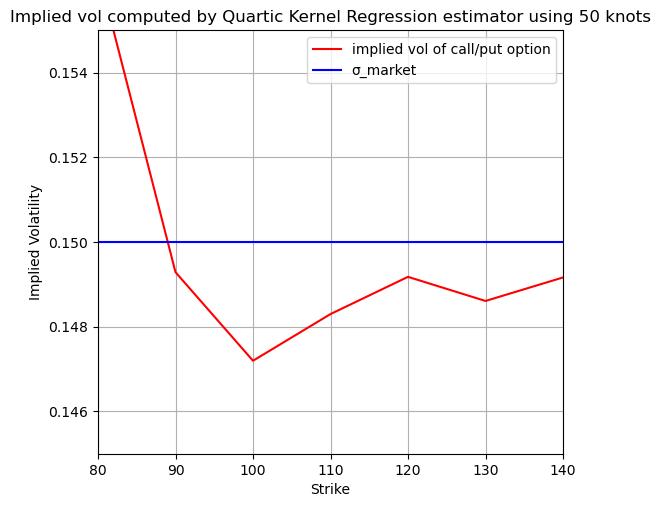

In [24]:
fig = plt.figure()
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.plot(strike, NW_implied_vols_opt, color = 'r', label='implied vol of call/put option')
plt.grid()
plt.ylim(0.145,0.155) # centered on σ_mkt
plt.axhline(σ_mkt, color = 'b', label='σ_market')
plt.title('Implied vol computed by Quartic Kernel Regression estimator using 50 knots')
plt.legend()
plt.grid()
plt.show()

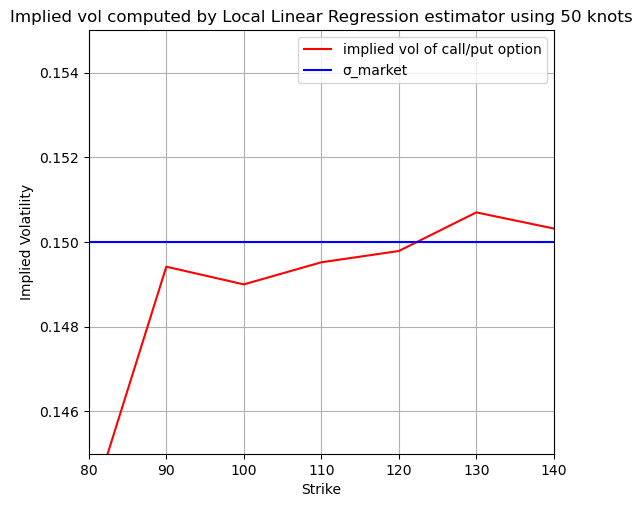

In [49]:
fig = plt.figure()
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.plot(strike, LL_implied_vols_opt, color = 'r', label='implied vol of call/put option')
plt.grid()
plt.ylim(0.145,0.155) # centered on σ_mkt
plt.axhline(σ_mkt, color = 'b', label='σ_market')
plt.title('Implied vol computed by Local Linear Regression estimator using 50 knots')
plt.legend()
plt.grid()
plt.show()

Quartic Kernel and Local Linear methods both provide small error for a certain range of strike. The fact that these two methods tend to give a worst estimation of $σ_{mkt}$ through a range of strike (especially around OTM strike) simply is a consequence of extrapolation algorithm. The following plots will agree with this point. One may see the relative error through the following graphs :

In [58]:
#NW_implied_vols_opt

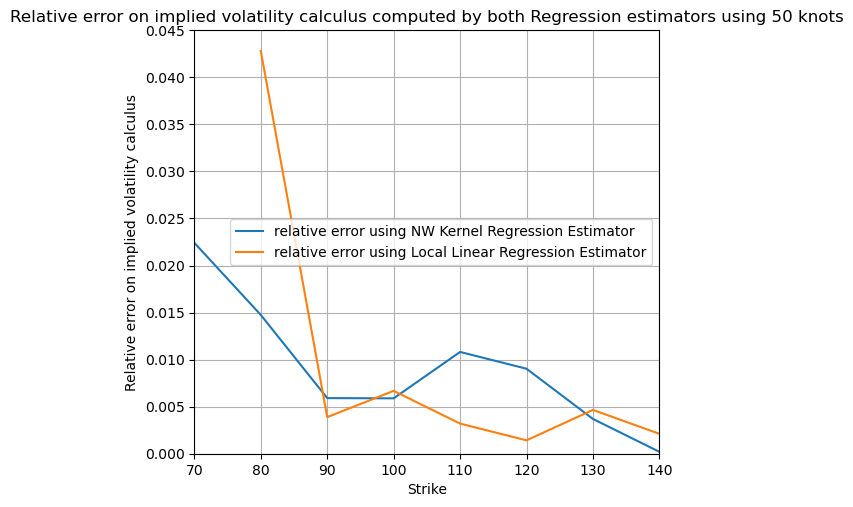

In [57]:
implied_vols_list = [NW_implied_vols_opt, LL_implied_vols_opt]
fig = plt.figure()
plt.xlabel('Strike')
plt.ylabel('Relative error on implied volatility calculus')
for implied_vols_opt in implied_vols_list :
    if implied_vols_opt == NW_implied_vols_opt :
        legend = str('NW Kernel Regression Estimator')
    else :
        legend = str('Local Linear Regression Estimator')
    rel_err_list = [abs(implied_vols_opt[i]-σ_mkt)/σ_mkt for i in range(len(implied_vols_opt))]
    plt.plot(strike, rel_err_list, label='relative error using ' + legend)
plt.grid()
#plt.ylim(0.145,0.155) # centered on σ_mkt
#plt.axhline(σ_mkt, color = 'b', label='σ_market')
plt.title('Relative error on implied volatility calculus computed by both Regression estimators using 50 knots')
plt.legend()
plt.grid()
plt.show()

One may conclude these two methods approximately give the same relative error but final pricing will approve this conjecture.

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\gamma$. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\gamma$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the smile on $\gamma$.

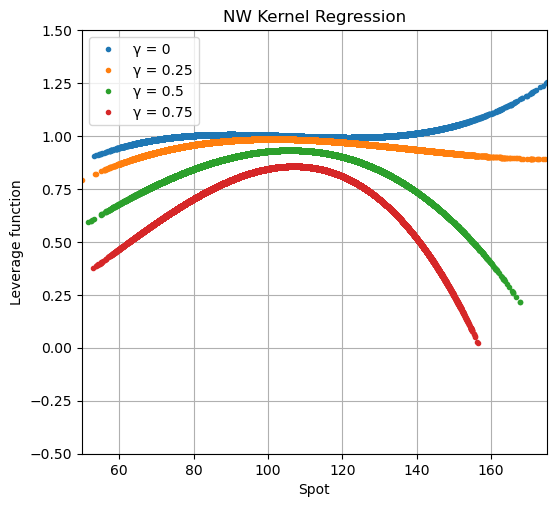

In [25]:
# new set of parameters
ρ2 = 0.0
κ2 = 1.0
gamma_list = [0, 0.25, 0.50, 0.75] # set of gamma we are going to study
ylim = [-0.5,1.5]

for γ in gamma_list:
    S, L_list = particle_method(N, S0, Y0, σ_0, Δ_T, ρ2, κ2, γ, T, σ_mkt, discret_scale_opt, q, kern = quartic_kern, degree = 3, method_ = 'NW')
    plt.plot(S[-1,:],L_list[-1](S[-1,:]), '.', lw = 0.1, label='γ = ' + str(γ))
plt.xlabel('Spot')
plt.ylabel('Leverage function')
plt.ylim(tuple(ylim))
plt.xlim(50,175)
plt.legend()
plt.grid(True)
plt.title('NW Kernel Regression')
plt.show()

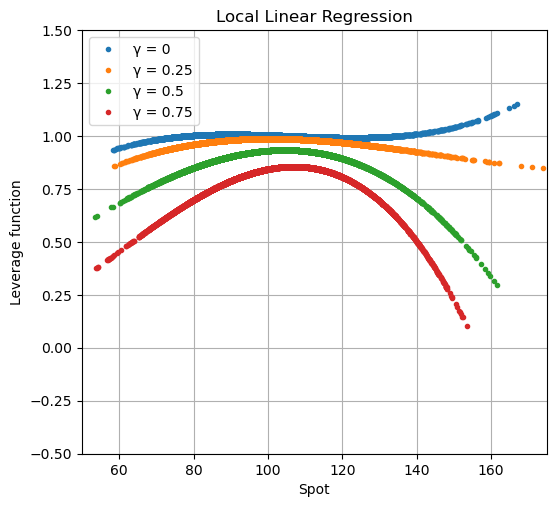

In [115]:
for γ in gamma_list:
    S, L_list = particle_method(N, S0, Y0, σ_0, Δ_T, ρ2, κ2, γ, T, σ_mkt, discret_scale_opt, q, kern = quartic_kern, degree = 3, method_ = 'LL')
    plt.plot(S[-1,:],L_list[-1](S[-1,:]), '.', lw = 0.1, label='γ = ' + str(γ))
plt.xlabel('Spot')
plt.ylabel('Leverage function')
plt.ylim(tuple(ylim))
plt.xlim(50,175)
plt.legend()
plt.grid(True)
plt.title('Local Linear Regression')
plt.show()

One can see in these two graphs that the concavity of the curves goes with $γ$. The biggest the $γ$ the biggest the concavity of the leverage function in fact. Moreover, $ γ = 0 $ implies $ Leverage function = 1 $ but it does make sense because $γ = 0$ implies that there is no Brownian dynamics in $Y$ and $Y$ is now totally deterministic. SLV model we are actually studying turns into a pure stochastic volatility model and may be perfectly calibrated. Let's see the corresponding smiles at maturity $T$ for the pure stochastic volatility model.
$\newline$
Moreover, as volatility of volatility coefficient $γ$ increases, if the average of the trajectories is out of the money for instance, it means that the Brownian dynamics tended to be downward, and thus, due to the negative correlation, the volatility is high and is not only intrinsically but positively linked to $γ$. Therefore, one may expect to observe a leverage function decreasing with $γ$ for a given spot price, and increasing with the spot price until a certain critical spot from which the leverage function decreases.
$\newline$
Conversely, if the average of the trajectories is in the money, it means that the Brownian dynamics tended to be upward, and thus, due to the negative correlation, the bigger the $γ$ the more the volatility is variable. Therefore, we expect to observe a leverage function decreasing with $γ$ for a given spot price, and decreasing with the spot price for a given $γ$.
$\newline$
Let's see the corresponding smiles at maturity $T$ for the pure stochastic volatility model.

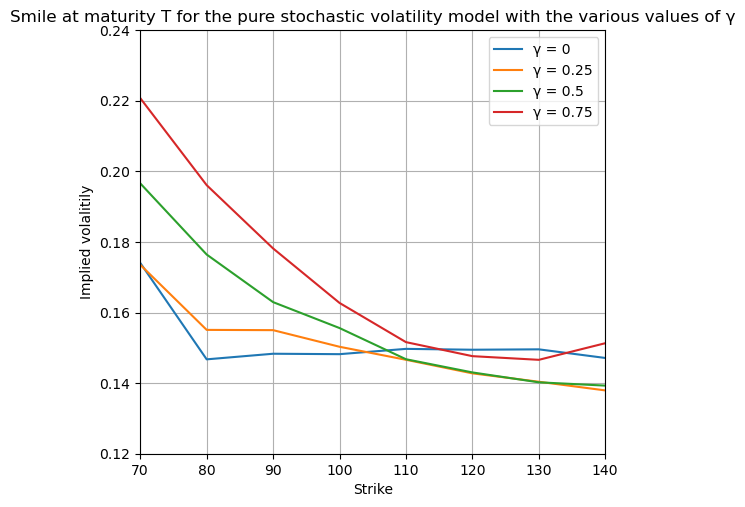

In [116]:
for γ in gamma_list:
    ## pure stochastic volatility model so the parameter 'leverage' is set to 'const'
    implied_vols = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2, κ, ρ, γ, discret_scale_opt, q, kern = quartic_kern, deg = 3, method = 'LL', leverage = 'const') for K in strike]
    plt.plot(strike,implied_vols, label='γ = ' + str(γ))

plt.xlabel('Strike')
plt.ylabel('Implied volalitily')
plt.legend()
plt.grid(True)
plt.title('Smile at maturity T for the pure stochastic volatility model with the various values of γ')
plt.show()

The average form of the smile that corresponds to $γ = 0$ agrees with what has been highlighted above (almost constant) because $γ = 0$ actually means that $Y$ is totally determistic so we are now studying a pure stochastic volatility model which is consistent with the rich joint dynamics of the asset and its implied volatility as we can see above. 
$\newline$
One may discuss further the trend of the smile corresponding to an increasing volatility of volatility coefficient $γ$. If the average of the trajectories is out of the money for instance, it means that the Brownian dynamics tended to be downward, and thus, due to the negative correlation, the realized volatility is high due to the volatility of volatility coefficient $γ$. Therefore, one may expect to observe a high implied volatility, with smile function that decreases with the spot price. To conclude with, the bigger the $γ$ the bigger the implied volatility.

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\rho$. Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\rho$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\rho$ in the same graph. Comment on the dependence of the shape of the leverage function on $\rho$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\rho$ in the same graph. Comment on the dependence of the shape of the smile on $\rho$.

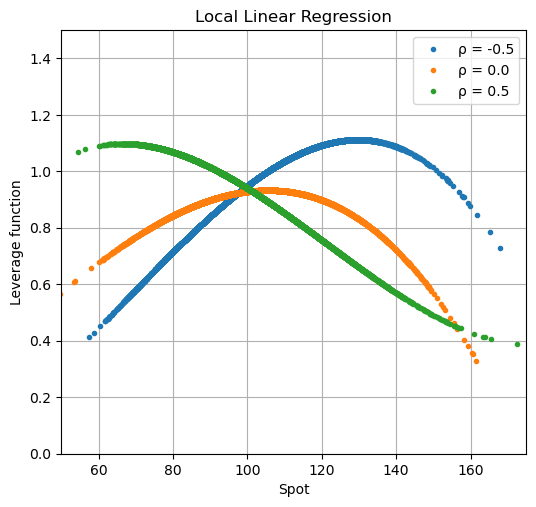

In [117]:
γ = 0.50
κ = 1
rho_list = [-0.50, 0.0, 0.50]
ylim = [0.0,1.5]

for ρ in rho_list:
    S, L_list = particle_method(N, S0, Y0, σ_0, Δ_T, ρ, κ, γ, T, σ_mkt, discret_scale_opt, q, kern = quartic_kern, degree = 3, method_ = 'LL')
    plt.plot(S[-1,:],L_list[-1](S[-1,:]), '.', lw = 0.1, label='ρ = ' + str(ρ))
plt.xlabel('Spot')
plt.ylabel('Leverage function')
plt.ylim(tuple(ylim))
plt.xlim(50,175)
plt.legend()
plt.grid(True)
plt.title('Local Linear Regression')
plt.show()

The average form of the leverage function that corresponds to $ρ = 0$ agrees with what has been highlighted above (almost symmetrical). 
$\newline$
One may discuss further the trend of the leverage function corresponding to coefficient of correlation $ρ = -0.5$. Such a coefficient means that spot and volatility tend to evolve with opposite way which is actually true in financial markets. If the average of the trajectories is out of the money, it means that the Brownian dynamics tended to be downward, and thus, due to the negative correlation, the volatility is higher than it should be. Therefore, we expect to observe a leverage function lower than 1, increasing with the spot price until a certain critical spot from which the leverage function decreases. 
$\newline $ Conversely, a positive correlation coefficient goes against what is observed in the market. If the average of the trajectories is in the money, it means that the Brownian dynamics tended to be upward, and thus, due to the positive correlation, the volatility is higher than it should be. Therefore, we expect to observe a leverage function lower than 1, decreasing with the spot price until a certain critical spot from which the leverage function increases.
The corresponding leverage function ensures the right spot-vol dynamics indeed. 
$\newline$
Let's see the corresponding smiles at maturity $T$ for the pure stochastic volatility model.

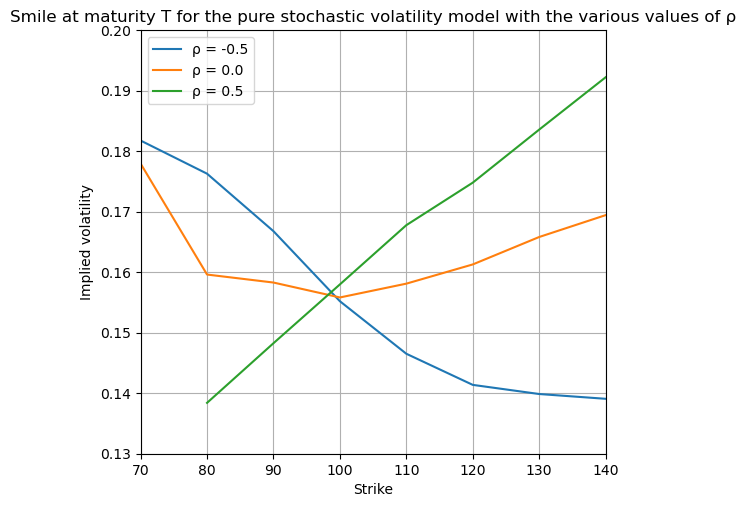

In [120]:
γ = 0.50
κ = 1
rho_list = [-0.50, 0.0, 0.50]

for ρ in rho_list:
    ## pure stochastic volatility model so the parameter 'leverage' is set to 'const'
    implied_vols = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2, κ, ρ, γ, discret_scale_opt, q, kern = quartic_kern, deg = 3, method = 'LL', leverage = 'const') for K in strike]
    plt.plot(strike,implied_vols, label='ρ = ' + str(ρ))

plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.legend()
plt.grid(True)
plt.title('Smile at maturity T for the pure stochastic volatility model with the various values of ρ')
plt.show()

The average form of the smile function that corresponds to $ρ = 0$ agrees with what has been highlighted above. 
$\newline$
One may discuss further the trend of the smile corresponding to coefficient of correlation $ρ = -0.5$. If the average of the trajectories is in the money, it means that the Brownian dynamics tended to be upward, and thus, due to the negative correlation, the realized volatility is low. Therefore, one may expect to observe an implied volatility decreasing with the spot price. 
$\newline$
Conversely, a positive correlation coefficient means that if the average of the trajectories is in the money, it means that the Brownian dynamics tended to be upward, and thus, due to the positive correlation, the realized volatility is high. Therefore, one may expect to observe an implied volatility increasing with the spot price.

<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\kappa$. Suggested values of $\kappa$: $0.1$, $1$, $10$.
- Recalibrate the leverage function $l(t,S)$ for each $\kappa$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the leverage function on $\kappa$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the smile on $\kappa$.

For this question, after debugging the code I have realized that a runtime warning error appears if $q > 0.01$. I decided to set $q = 0.025$ for this part only as a result. (But rerun remains sometimes necessary)

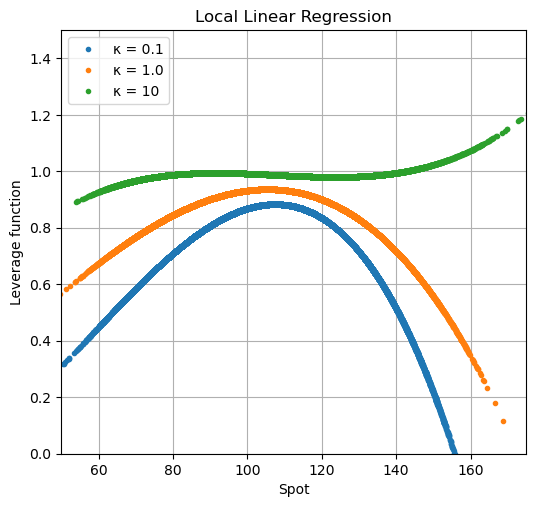

In [26]:
ρ = 0
γ = 0.50
kappa_list = [0.1, 1.0, 10]
ylim = [0.0, 1.5]
q2 = 0.01 ## new quartile as mentionned above // reducing the range

## S, L_list = particle_method(N, S0, Y0, σ_0, Δ_T, ρ, κ, γ, T, σ_mkt, discret_scale_opt, kern = quartic_kern, degree = 3)

for κ in kappa_list:
    S, L_list = particle_method(N, S0, Y0, σ_0, Δ_T, ρ, κ, γ, T, σ_mkt, discret_scale_opt, q2, kern = quartic_kern, degree = 3, method_ = 'LL')
    plt.plot(S[-1,:],L_list[-1](S[-1,:]), '.', lw = 0.1, label='κ = ' + str(κ))
plt.xlabel('Spot')
plt.ylabel('Leverage function')
plt.ylim(tuple(ylim))
plt.xlim(50,175)
plt.legend()
plt.grid(True)
plt.title('Local Linear Regression')
plt.show()

The fact that the biggest $κ$ the less the concavity of the leverage function is actually consistent. A high mean-reverting speed $κ$ means that $Y$ will be almost deterministic and equals to its mean $\bar{Y}$. Now that one has, almost surely, $Y = \bar{Y}$, it turns out that SLV model we are actually studying is now a pure stochastic volatility model and may be perfectly calibrated, that's why $Leverage function \approx 1$. 
$\newline$
Moreover, as $κ$ decreases, the volatility's dependancy on Brownian dynamics becomes more and more important. If the average of the trajectories is out of the money for instance, it means that the Brownian dynamics tended to be downward, and thus, due to the negative correlation, the volatility is high and is not only intrinsically but positively linked to the decrease of $κ$ : the leverage function, seen as a function of $κ$, must be decreasing so as to partially offset the high volatility. Therefore, one may expect to observe a leverage function decreasing with $κ$ for a given spot price, and increasing with the spot price until a certain critical spot from which the leverage function decreases.
$\newline$
Let's see the corresponding smiles at maturity $T$ for the pure stochastic volatility model.

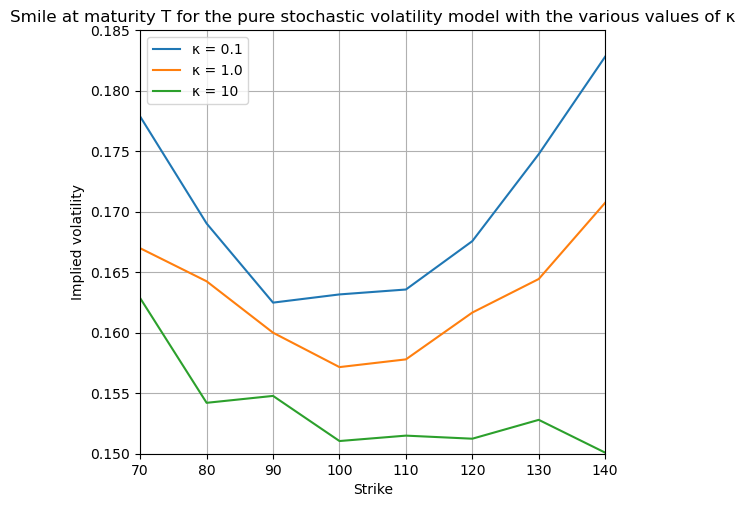

In [122]:
for κ in kappa_list :
    ## pure stochastic volatility model so the parameter 'leverage' is set to 'const'
    implied_vols = [implied_volatility_calculus(S0, Y0, T, K, Δ_T, σ_0, σ_mkt, N1, N2, κ, ρ, γ, discret_scale_opt, q2, kern = quartic_kern, deg = 3, method = 'LL', leverage = 'const') for K in strike]
    plt.plot(strike,implied_vols, label='κ = ' + str(κ))

plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.legend()
plt.grid(True)
plt.title('Smile at maturity T for the pure stochastic volatility model with the various values of κ')
plt.show()

One may discuss further the trend of the smile function corresponding to coefficient of mean-reverting $κ$. 
$\newline$
The leverage function, seen as a function of $κ$, must be decreasing. In fact, if the average of the trajectories is out the money, it means that the Brownian dynamics tended to be downward, and thus, due to the negative correlation, the realized volatility is high. Moreover, the fact that the smaller the $κ$ the bigger the volatility's dependancy on Brownian dynamics is proving that realized volatility is positively correlated with the decrase of $κ$. Therefore, one may expect to observe an implied volatility, seen as a function of $κ$, that actually decreases with $κ$ for a given spot price.
$\newline$
The fact that the biggest $κ$ is the less the convexity of the leverage function is actually consistent. A high mean-reverting speed $κ$ means that $Y$ will be almost deterministic and equals to its mean $\bar{Y}$ regardless of the Brownian dynamics. Therefore, one may expect to observe an implied volatility becoming more and more constant as $κ$ increases. 
$\newline$
Conversely, a low mean-reverting speed $κ$ means that $Y$ will be even more dependant on the Brownian dynamics. Therefore, one may expect to observe an implied volatility becoming more and more convex as the strike is getting far from the ATM strike. 

<b>(e).</b> Consider the forward-starting call spread with payoff
\begin{equation*}
\left( \frac{S_{T_2}}{S_{T_1}}-0.95 \right)_+ - \left( \frac{S_{T_2}}{S_{T_1}}-1.05 \right)_+
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

In [123]:
def forward_starting_call_spread(S0, Y0, T1, T2, K1, K2, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale, q, kern = quartic_kern, degree_ = 3, method = 'NW', leverage = 'variable'):
### based on implied_volatility_calculus function
    _, L_list = particle_method(N1, S0, Y0, σ_0, Δ_T, ρ, κ, γ, T, σ_mkt, discret_scale, q, kern = quartic_kern, degree = degree_, method_= method)
    S1 = np.zeros((int(T1/Δ_T),N2))
    Y1 = np.zeros((int(T1/Δ_T),N2))
    Y1[0,:] = Y0
    S1[0,:] = S0
    L_t_S = np.ones(N2)

    for i in range(int(T1/Δ_T)-1):
        if leverage == 'variable':
            L_t_S = np.polyval(L_list[i], S1[i,:])
        S1,Y1 = euler_step(S1, Y1, N2, σ_0, Δ_T, ρ, κ, γ, T1, i, L_t_S)

    S2 = np.zeros((int(T2/Δ_T),N2))
    Y2 = np.zeros((int(T2/Δ_T),N2))
    Y2[0,:] = Y0
    S2[0,:] = S0
    L_t_S = np.ones(N2)

    for i in range(int(T2/Δ_T)-1):
        if leverage == 'variable':
            L_t_S = np.polyval(L_list[i], S2[i,:])
        S2,Y2 = euler_step(S2, Y2, N2, σ_0, Δ_T, ρ, κ, γ, T2, i, L_t_S)


    call_price = np.mean(np.maximum(S2[-1,:]/S1[-1,:] - K1, 0))-np.mean(np.maximum(S2[-1,:]/S1[-1,:] - K2, 0))
    return call_price

In [124]:
## parameters needed so as to calculate forward starting call spread price
T1, T2 = 1-3/12, 1
K1, K2 = 0.95, 1.05
S0, Y0 = 100, 0
γ, ρ, σ_0, κ = 1.0, -0.5, 0.15, 1.0

In [126]:
NW_SLV_price = forward_starting_call_spread(S0, Y0, T1, T2, K1, K2, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale_opt, q,  kern = quartic_kern, degree_ = 3, method = 'NW', leverage = 'variable')
print('Pricing of the forward starting call spread using NW Kernel SLV model = ', NW_SLV_price)

LL_SLV_price = forward_starting_call_spread(S0, Y0, T1, T2, K1, K2, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale_opt, q, kern = quartic_kern, degree_ = 3, method = 'LL', leverage = 'variable')
print('Pricing of the forward starting call spread using Local Linear SLV model = ', LL_SLV_price)

BS_price = blackscholes_price(K1, T2-T1, 1, σ_0, r = 0, q = 0, callput='call') - blackscholes_price(K2, T2 - T1, 1, σ_0, r = 0, q = 0, callput='call')
print('Pricing of the forward starting call spread using BS model = ', BS_price)

Pricing of the forward starting call spread using NW Kernel SLV model =  0.049482875893583744
Pricing of the forward starting call spread using Local Linear SLV model =  0.049660821308697964
Pricing of the forward starting call spread using BS model =  0.04880247873674198


###### NB : sometimes this function returns NaN because it is involving potentially unstable operations (division by small numbers for instance or even negative call price which returns NaN by default) but one may surely obtain a satisfying result after running the code less than 3 times (which is honestly acceptable because of the high speed of the code's execution).

One way to solve this problem is to calculate the price several times and then calculate the average price with non consideration for NaN values or 0.0 : one may obtain a more precise price indeed.

In [127]:
import math
NW_SLV_price_list = []
LL_SLV_price_list = []
for k in range(10): ## 10 pricing simulations
    NW_SLV_price = forward_starting_call_spread(S0, Y0, T1, T2, K1, K2, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale_opt, q, kern = quartic_kern, degree_ = 3, method = 'NW', leverage = 'variable')
    LL_SLV_price = forward_starting_call_spread(S0, Y0, T1, T2, K1, K2, Δ_T, σ_0, σ_mkt, N1, N2,  κ, ρ, γ, discret_scale_opt, q, kern = quartic_kern, degree_ = 3, method = 'LL', leverage = 'variable')
    if not (math.isnan(NW_SLV_price) or NW_SLV_price == 0.0):
        NW_SLV_price_list.append(NW_SLV_price)
    if not (math.isnan(LL_SLV_price) or LL_SLV_price == 0.0):
        LL_SLV_price_list.append(LL_SLV_price)
NW_SLV_price = np.mean(NW_SLV_price_list)
LL_SLV_price = np.mean(LL_SLV_price_list)

print('Pricing of the forward starting call spread using NW Kernel SLV model = ', NW_SLV_price)
print('Pricing of the forward starting call spread using Local Linear SLV model = ', LL_SLV_price)

C:\Users\tocad\AppData\Local\Temp\ipykernel_33080\1294181074.py:27: RuntimeWarning: divide by zero encountered in true_divide
  call_price = np.mean(np.maximum(S2[-1,:]/S1[-1,:] - K1, 0))-np.mean(np.maximum(S2[-1,:]/S1[-1,:] - K2, 0))
C:\Users\tocad\AppData\Local\Temp\ipykernel_33080\1294181074.py:27: RuntimeWarning: invalid value encountered in double_scalars
  call_price = np.mean(np.maximum(S2[-1,:]/S1[-1,:] - K1, 0))-np.mean(np.maximum(S2[-1,:]/S1[-1,:] - K2, 0))


Pricing of the forward starting call spread using NW Kernel SLV model =  0.04963631117651443
Pricing of the forward starting call spread using Local Linear SLV model =  0.049677912565667386


### Conclusion and error estimation

In [128]:
NW_err_relative = (abs(NW_SLV_price-BS_price)/BS_price)*100
print('Soit une erreur relative de : ', np.round(NW_err_relative,4), '% pour NW Kernel Regression estimator')
LL_err_relative = (abs(LL_SLV_price-BS_price)/BS_price)*100
print('Soit une erreur relative de : ', np.round(LL_err_relative,4), '% pour Local Linear Regression estimator')

Soit une erreur relative de :  1.7086 % pour NW Kernel Regression estimator
Soit une erreur relative de :  1.7938 % pour Local Linear Regression estimator


However small these errors may be it turns out that they are too serious mispricing for the financial markets and its highly demanding request toward pricing. Conversely, SLV models can be particularly useful in path-dependent options pricing, where the payoff depends not only on the terminal price of the underlying asset but also on its entire path. The ability to model changing volatility over time enhances the accuracy of pricing for these complex options.

To conclude with, one may wonder the option pricing dependancy on the regression estimator (NW Kernel vs Local Linear Regression estimator). However, the difference between both methods clearly is non-significant compared to the error due to the approximation method as one may see below.

In [129]:
reg_estim_relative_dev = (abs((NW_SLV_price-LL_SLV_price))/NW_SLV_price)*100
print('Soit un écart relatif liée au choix du regression estimator de : ', np.round(reg_estim_relative_dev,4), '%')
print('Then, the choice of regression estimator seems to be', int(np.round((np.round(NW_err_relative,4) + np.round(LL_err_relative,4)) / (2 * np.round(reg_estim_relative_dev,4)))), 'times less important than the source of error behind implied volatility calculus approximation in terms of statistical estimate errors.')

Soit un écart relatif liée au choix du regression estimator de :  0.0838 %
Then, the choice of regression estimator seems to be 21 times less important than the source of error behind implied volatility calculus approximation in terms of statistical estimate errors.
